In [1]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Load image paths and assign categories (1 to 21)
image_dir = r"C:\Users\User\Downloads\UCMerced_LandUse\Images"
categories = list(range(1, 22))  # 1 to 21
image_paths, image_labels = [], []

for idx, folder in enumerate(sorted(os.listdir(image_dir))):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.endswith('.tif'):  # Filter .tif images
                image_paths.append(os.path.join(folder_path, img_file))
                image_labels.append(categories[idx])

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)


In [3]:
image_to_check = Image.open(image_paths[2099])
image_to_check.show()

In [4]:
# Split into training (70%), validation (10%), and testing (20%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.6667, stratify=test_labels, random_state=42)


In [5]:
def extract_sift_features(image_path):
    try:
        # Load .tif image using PIL
        img = Image.open(image_path).convert('L')
        img = np.array(img)

        # SIFT feature extraction
        sift = cv2.SIFT_create()
        _, descriptors = sift.detectAndCompute(img, None)
        return descriptors
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


In [11]:
def build_codebook(image_paths, n_clusters):
    all_descriptors = []
    for img_path in image_paths:
        descriptors = extract_sift_features(img_path)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    # Stack all descriptors for clustering
    all_descriptors = np.vstack(all_descriptors)

    # KMeans clustering to create the codebook
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


In [7]:
def create_histogram(descriptors, kmeans):
    histogram = np.zeros(kmeans.n_clusters)
    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for cluster in cluster_assignments:
            histogram[cluster] += 1
    return histogram


In [8]:
from sklearn.model_selection import StratifiedKFold

def perform_k_fold(image_paths, image_labels, n_clusters_values, k_folds=3):
    results = {}

    # Perform k-fold cross-validation for each n_clusters value
    for n_clusters in n_clusters_values:
        print(f"Evaluating for n_clusters = {n_clusters}...")
        fold_accuracies = []
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        for train_idx, val_idx in skf.split(image_paths, image_labels):
            # Split training and validation data
            train_paths, val_paths = image_paths[train_idx], image_paths[val_idx]
            train_labels, val_labels = image_labels[train_idx], image_labels[val_idx]

            # Build codebook with current fold's training data
            kmeans = build_codebook(train_paths, n_clusters)

            # Create histograms for training and validation images
            X_train_hist = np.array([create_histogram(extract_sift_features(img), kmeans) for img in train_paths])
            X_val_hist = np.array([create_histogram(extract_sift_features(img), kmeans) for img in val_paths])

            # Train KNN and evaluate
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train_hist, train_labels)
            val_predictions = knn.predict(X_val_hist)
            accuracy = accuracy_score(val_labels, val_predictions)
            fold_accuracies.append(accuracy)

        # Average accuracy across folds
        avg_accuracy = np.mean(fold_accuracies)
        results[n_clusters] = avg_accuracy
        print(f"n_clusters = {n_clusters}, Average Validation Accuracy = {avg_accuracy:.4f}")

    return results


In [12]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [12]:
pip install --upgrade scikit-learn numpy

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\~klearn\\cluster\\_dbscan_inner.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




     --------------------------------------- 11.1/11.1 MB 12.8 MB/s eta 0:00:00
  Using cached numpy-2.2.2-cp310-cp310-win_amd64.whl (12.9 MB)
     -------------------------------------- 301.8/301.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


In [13]:
# Define the number of clusters to evaluate
from sklearn.neighbors import KNeighborsClassifier
n_clusters_values = [100, 200, 300, 400, 500, 600, 700, 800]

# Perform k-fold cross-validation
results = perform_k_fold(train_paths, train_labels, n_clusters_values, k_folds=3)

# Find the optimal number of codewords
optimal_n_clusters = max(results, key=results.get)
print(f"Optimal number of codewords: {optimal_n_clusters}")

# Rebuild the final model with the optimal number of codewords
kmeans_optimal = build_codebook(train_paths, optimal_n_clusters)

# Create histograms for test data
X_test_hist = np.array([create_histogram(extract_sift_features(img), kmeans_optimal) for img in test_paths])

# Train KNN on all training data with optimal codebook
X_train_hist = np.array([create_histogram(extract_sift_features(img), kmeans_optimal) for img in train_paths])
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(X_train_hist, train_labels)

# Evaluate on the test set
test_predictions = knn_final.predict(X_test_hist)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with Optimal Codewords ({optimal_n_clusters}): {test_accuracy * 100:.2f}%")


Evaluating for n_clusters = 100...
n_clusters = 100, Average Validation Accuracy = 0.6041
Evaluating for n_clusters = 200...
n_clusters = 200, Average Validation Accuracy = 0.5755
Evaluating for n_clusters = 300...
n_clusters = 300, Average Validation Accuracy = 0.5748
Evaluating for n_clusters = 400...
n_clusters = 400, Average Validation Accuracy = 0.5476
Evaluating for n_clusters = 500...
n_clusters = 500, Average Validation Accuracy = 0.5388
Evaluating for n_clusters = 600...
n_clusters = 600, Average Validation Accuracy = 0.5170
Evaluating for n_clusters = 700...
n_clusters = 700, Average Validation Accuracy = 0.4884
Evaluating for n_clusters = 800...
n_clusters = 800, Average Validation Accuracy = 0.4612
Optimal number of codewords: 100
Test Accuracy with Optimal Codewords (100): 58.67%


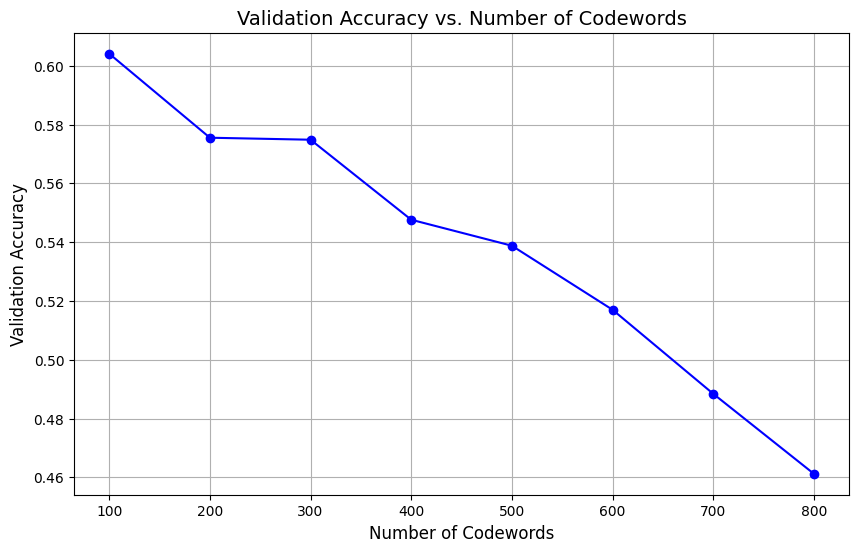

In [14]:
# Plot validation accuracy for each number of codewords
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_values, [results[n] for n in n_clusters_values], marker='o', color='b')
plt.title("Validation Accuracy vs. Number of Codewords", fontsize=14)
plt.xlabel("Number of Codewords", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.grid()
plt.show()


In [15]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_sift_keypoints_tsne(image_paths, labels, n_samples=500):
    """
    Visualize SIFT keypoints using t-SNE.

    Parameters:
    - image_paths: List of image file paths.
    - labels: Corresponding labels for the images.
    - n_samples: Number of images to sample for visualization.
    """
    # Sample images to reduce computation
    sampled_paths = image_paths[:n_samples]
    sampled_labels = labels[:n_samples]

    # Extract SIFT descriptors
    all_descriptors = []
    descriptor_labels = []
    for img_path, label in zip(sampled_paths, sampled_labels):
        descriptors = extract_sift_features(img_path)
        if descriptors is not None:
            all_descriptors.append(descriptors)
            descriptor_labels.extend([label] * len(descriptors))

    # Combine all descriptors
    all_descriptors = np.vstack(all_descriptors)

    # Reduce dimensions using t-SNE
    print("Performing t-SNE on SIFT descriptors...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    reduced_descriptors = tsne.fit_transform(all_descriptors)

    # Visualize
    print("Visualizing t-SNE results...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=reduced_descriptors[:, 0],
        y=reduced_descriptors[:, 1],
        hue=descriptor_labels,
        palette="tab20",
        legend="full",
        s=10,
    )
    plt.title("t-SNE Visualization of SIFT Keypoints", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


Performing t-SNE on SIFT descriptors...


C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualizing t-SNE results...


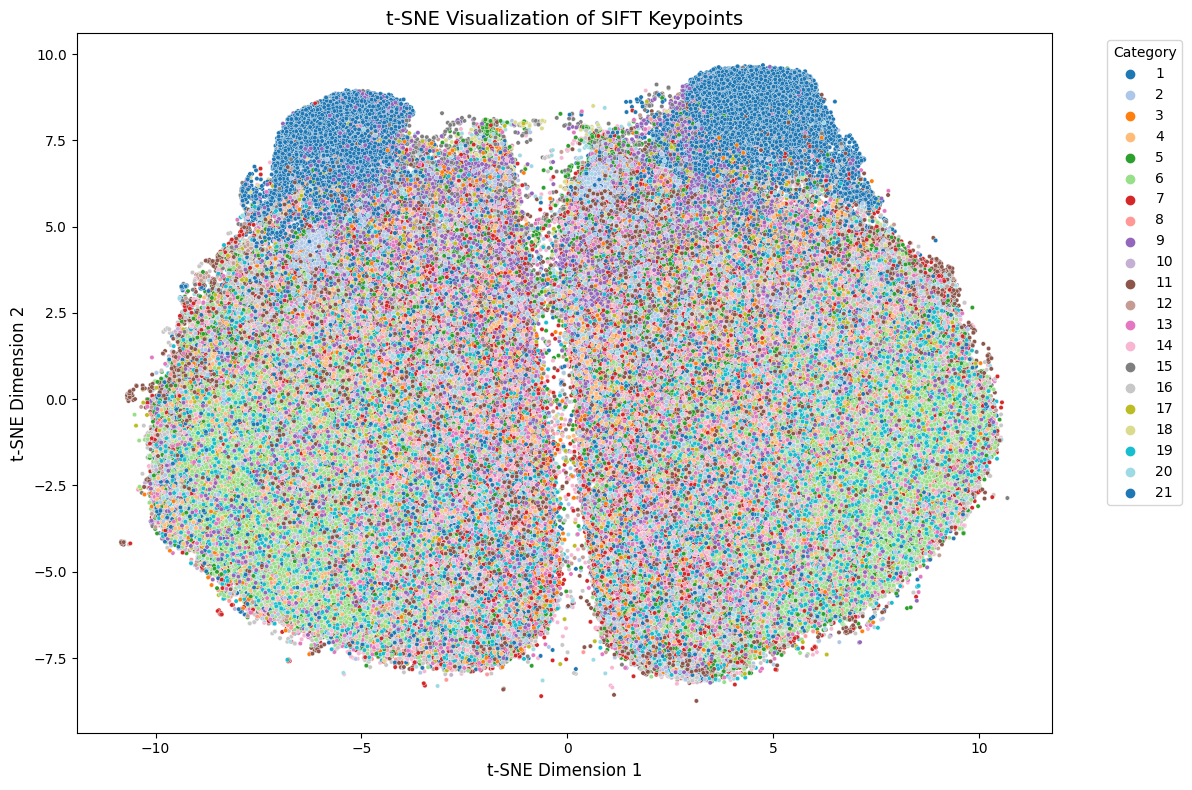

In [16]:
# Visualize SIFT keypoints using t-SNE for the training set
visualize_sift_keypoints_tsne(train_paths, train_labels, n_samples=500)
